In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pulsestreamer as ps
import time
from tqdm import tqdm
from scipy.optimize import curve_fit
import visa
from pylablib.devices import Thorlabs
mw = mw_source_smbv

In [2]:
def meas_counts(t_int = 5):
    afm_scanner_logic._counter._tagger.sync()
    afm_scanner_logic._counter.countrate.startFor(int(t_int*1e9), clear = True)
    afm_scanner_logic._counter.countrate.waitUntilFinished(timeout=int(t_int*20))
    return np.nan_to_num(afm_scanner_logic._counter.countrate.getData())[0]

In [3]:
Thorlabs.list_kinesis_devices()

[('74000603', 'Piezo Motor Controller')]

In [4]:
conn = '74000603'
# if rot_stage:
#     rot_stage.close()
rot_stage = Thorlabs.KinesisPiezoMotor(conn = conn) #Make sure the Kensis program is closed
rot_stage.setup_drive(max_voltage=85, velocity=2000, acceleration=10000)

TPZMotorDriveParams(max_voltage=85, velocity=2000, acceleration=10000)

In [5]:
step_range = np.linspace(0.0, 8000, 30)
N = 50

#Driving information for the first LO (SMBV)
target_freq = 2.87704e9
power = -20

Measurement loop for polarisation without MW

In [6]:
counts = np.zeros_like(step_range)
counts_err = np.zeros_like(step_range)
counts_MW = np.zeros_like(step_range)
counts_MW_err = np.zeros_like(step_range)
contrast = np.zeros_like(step_range)#
contrast_err = np.zeros_like(step_range)

for i, step in enumerate(tqdm(step_range)):
    
    rot_stage.wait_move()
    rot_stage.move_to(position = int(step))
    rot_stage.wait_move()
    
    counts_temp = np.zeros(N)
    for k in range(N):
        counts_temp[k] = meas_counts()
    counts[i] = np.mean(counts_temp)
    counts_err[i] = np.std(counts_temp)

100%|#####################################################################################| 30/30 [02:33<00:00,  5.10s/it]


Measurement loop for polarisation with MW

In [10]:
counts = np.zeros_like(step_range)
counts_err = np.zeros_like(step_range)
counts_MW = np.zeros_like(step_range)
counts_MW_err = np.zeros_like(step_range)
contrast = np.zeros_like(step_range)#
contrast_err = np.zeros_like(step_range)

mw.off()
mw.set_cw(target_freq, power)
afm_scanner_logic.run_IQ_DC()

for i, step in enumerate(tqdm(step_range)):

    rot_stage.wait_move()
    rot_stage.move_to(position = int(step))
    rot_stage.wait_move()

        
    #Run measurement with MW off
    counts_temp = np.zeros(N)
    for k in range(N):
        counts_temp[k] = meas_counts()
    counts[i] = np.mean(counts_temp)
    counts_err[i] = np.std(counts_temp)
    
    #Run measurement with MW on
    mw.cw_on()
    counts_temp = np.zeros(N)
    for k in range(N):
        counts_temp[k] = meas_counts()
    counts_MW[i] = np.mean(counts_temp)
    counts_MW_err[i] = np.std(counts_temp)
    mw.off()

contrast = (1-counts_MW/counts)*100
contrast_err = np.sqrt((-100/counts*counts_MW_err)**2+(100*counts_MW/counts**2*counts_err)**2)

100%|####################################################################################| 20/20 [00:46<00:00,  2.32s/it]


Plotting

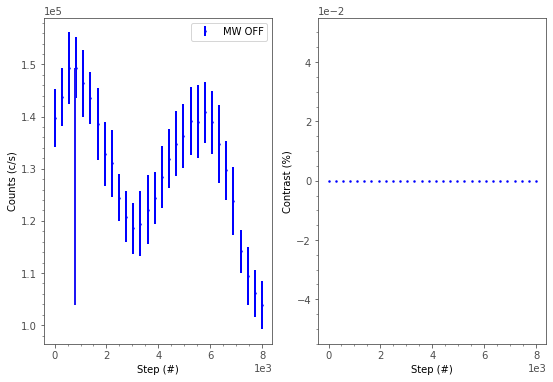

In [8]:
position = 800

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.errorbar(x=step_range, y=counts,
                         yerr=counts_err, fmt='b.', label=f'MW OFF')
# ax1.errorbar(x=step_range, y=counts_MW,
#                          yerr=counts_MW_err, fmt='r.', label=f'MW ON')
ax1.vlines(position,min(counts),max(counts))
ax1.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax1.set_xlabel('Step (#)')
ax1.set_ylabel('Counts (c/s)')

ax2.errorbar(x=step_range, y=contrast,
                         yerr=contrast_err, fmt='b.')
ax2.vlines(position,min(contrast),max(contrast))
ax2.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
ax2.set_xlabel('Step (#)')
ax2.set_ylabel('Contrast (%)')

ax1.legend()
plt.show()


In [9]:
rot_stage.move_to(position = position)
rot_stage.wait_move()

Traceback (most recent call last):
  File "C:\Users\yy3\Documents\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-8ba009b7aefd>", line 2, in <module>
    rot_stage.wait_move()
  File "C:\Users\yy3\anaconda3\envs\qudi\lib\site-packages\pylablib\devices\Thorlabs\kinesis.py", line 494, in _wait_move
    return self._wait_for_status(self._moving_status,False,channel=channel,timeout=timeout)
  File "C:\Users\yy3\anaconda3\envs\qudi\lib\site-packages\pylablib\core\utils\general.py", line 1107, in wrapped
    res=func(**all_args)
  File "C:\Users\yy3\anaconda3\envs\qudi\lib\site-packages\pylablib\devices\Thorlabs\kinesis.py", line 373, in _wait_for_status
    curr_status=self._default_get_status(channel=channel)
  File "C:\Users\yy3\anaconda3\envs\qudi\lib\site-packages\pylablib\core\utils\general.py", line 1107, in wrapped
    res=func(**all_args)
  File "C:\Users\yy3\anaconda3\envs\qudi\li

Save routine

In [13]:
filelabel = 'A-H12-13'
parameters = {}
data =  {'Step (#), Counts (c/s)': np.array((step_range, counts)).T}
filepath = savelogic.get_path_for_module(module_name='Polarisation')
savelogic.save_data(data, parameters=parameters, filepath=filepath, filelabel=filelabel, plotfig=fig, delimiter='\t')